<h1>Comparing LightGBM, Random Forest and SVM</h1>

Training LightGBM...
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

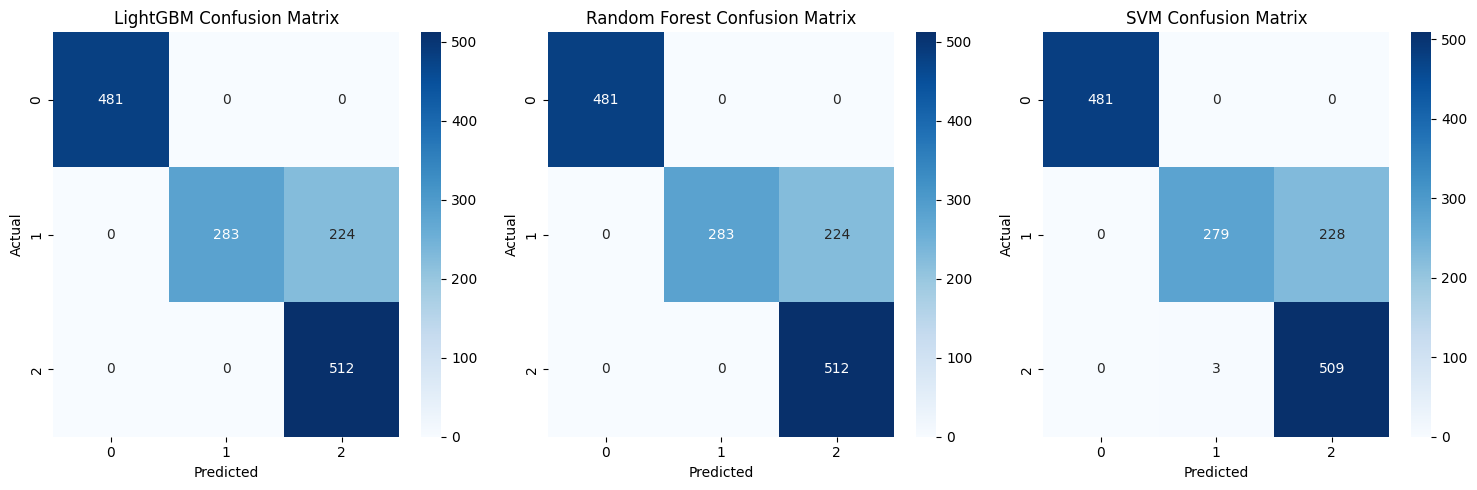

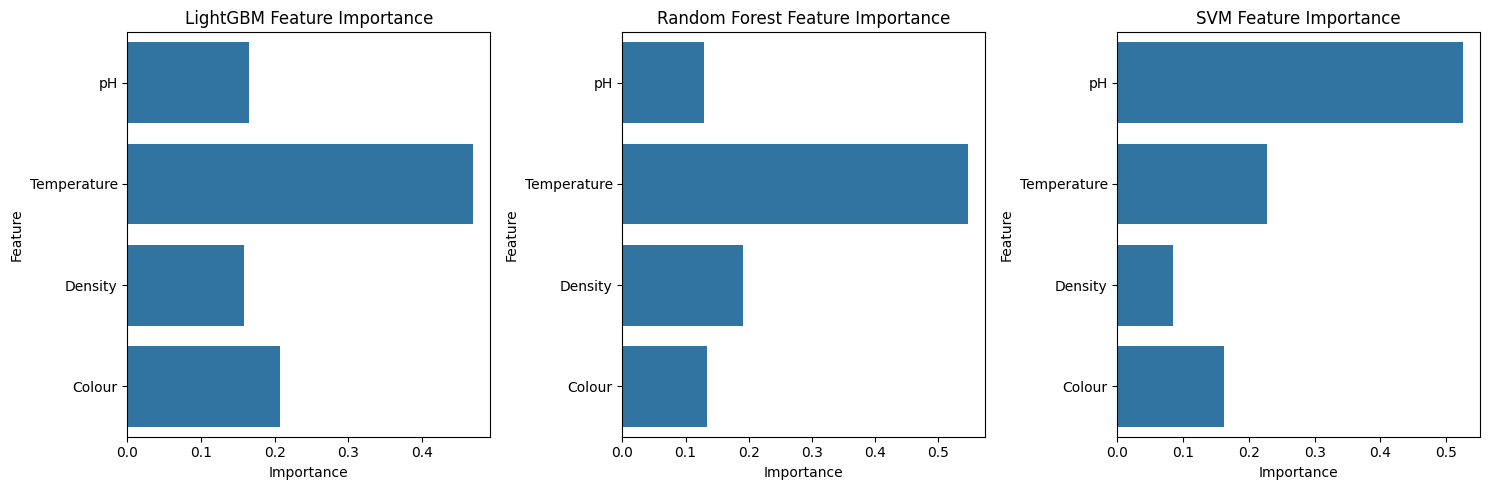

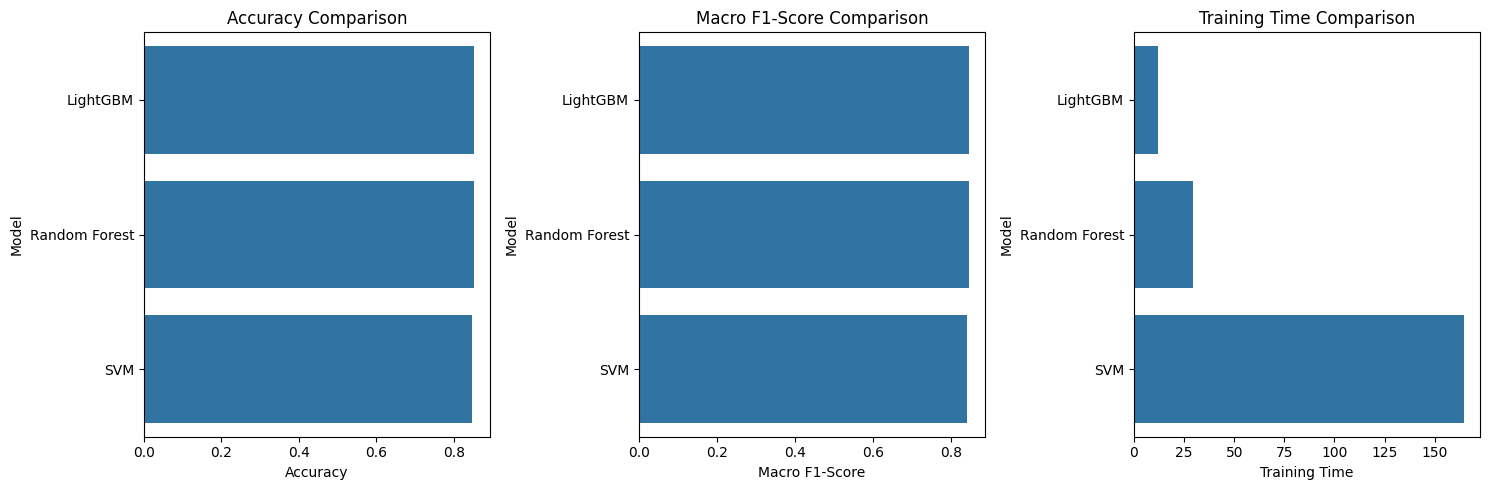

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import pickle
import warnings
warnings.filterwarnings('ignore')

# Create models directory
if not os.path.exists('models'):
    os.makedirs('models')

# Load and prepare data
train_data = pd.read_csv('datasets/milk_quality_data.csv')
X = train_data.drop('Grade', axis=1)
y = train_data['Grade']

# Scale features to prioritize pH
scaler = StandardScaler()
# Fit the scaler on the entire DataFrame at once
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
# Apply scaling factors, increase pH scaling to 4.0x
X_scaled['pH'] = X_scaled['pH'] * 4.0  # Increased from 2.0 to 4.0
X_scaled['Temperature'] = X_scaled['Temperature'] * 1.5
X_scaled['Colour'] = X_scaled['Colour'] * 1.2
X_scaled['Density'] = X_scaled['Density'] * 0.8

# Save the scaler for use in prediction cells
with open('models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Split data with a validation set for early stopping in LightGBM
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Compute sample weights for imbalance (post-SMOTE)
class_weights = dict(zip(np.unique(y_train), 1 / pd.Series(y_train).value_counts(normalize=True)))
sample_weights_train = np.array([class_weights[yi] for yi in y_train])

# Define hyperparameter distributions for RandomizedSearchCV
lgb_param_dist = {
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 150],
    'num_leaves': [15, 31],
    'min_child_weight': [1e-3, 0.1],
    'max_bin': [64, 128],
    'scale_pos_weight': [1, 2]
}

rf_param_dist = {
    'n_estimators': [500, 1000, 2000],  # Increased to slow down training
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8]
}

svm_param_dist = {
    'C': [0.1, 1, 10, 100, 1000],
    'kernel': ['rbf', 'linear', 'poly'],
    'gamma': ['scale', 'auto', 0.01, 0.1],
    'degree': [2, 3, 4]
}

# Initialize models with different random seeds for diversity
lgb_model = lgb.LGBMClassifier(objective='multiclass', num_class=3, random_state=42, verbosity=0)
rf_model = RandomForestClassifier(random_state=43)
svm_model = SVC(random_state=44, probability=True)

# Perform RandomizedSearchCV for each model
models = {
    'LightGBM': RandomizedSearchCV(
        lgb_model, lgb_param_dist, n_iter=10, cv=3, scoring='f1_macro', n_jobs=-1, random_state=42
    ),
    'Random Forest': RandomizedSearchCV(
        rf_model, rf_param_dist, n_iter=20, cv=3, scoring='f1_macro', n_jobs=-1, random_state=43
    ),
    'SVM': RandomizedSearchCV(
        svm_model, svm_param_dist, n_iter=10, cv=3, scoring='f1_macro', n_jobs=-1, random_state=44
    )
}

results = {}
feature_importance = {}
training_times = {}
prediction_times = {}

# Train and evaluate each model
for name, search in models.items():
    print(f"Training {name}...")
    start_time = time.time()
    # Fit the model using RandomizedSearchCV (no early stopping here)
    search.fit(X_train, y_train, sample_weight=sample_weights_train)
    
    # For LightGBM, refit with early stopping after finding the best parameters
    if name == 'LightGBM':
        best_params = search.best_params_
        # Create a new LightGBM model with the best parameters and set verbosity
        lgb_model = lgb.LGBMClassifier(
            **best_params,
            objective='multiclass',
            num_class=3,
            random_state=42,
            verbosity=0
        )
        # Refit with early stopping using the callbacks parameter
        start_time_refit = time.time()
        lgb_model.fit(
            X_train, y_train,
            sample_weight=sample_weights_train,
            eval_set=[(X_val, y_val)],
            eval_metric='multi_logloss',
            callbacks=[lgb.early_stopping(stopping_rounds=5)]
        )
        training_times[name] = (time.time() - start_time_refit) + (start_time_refit - start_time)
        best_model = lgb_model
    else:
        training_times[name] = time.time() - start_time
        best_model = search.best_estimator_
    
    # Test set predictions and measure prediction time
    start_time = time.time()
    y_pred = best_model.predict(X_test)
    prediction_times[name] = time.time() - start_time
    
    # Evaluate model
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    cm = confusion_matrix(y_test, y_pred)
    results[name] = {
        'model': best_model,
        'accuracy': accuracy,
        'f1_score': f1,
        'confusion_matrix': cm,
        'predictions': y_pred
    }
    
    # Compute feature importance
    if name in ['LightGBM', 'Random Forest']:
        feature_importance[name] = pd.DataFrame({
            'Feature': X.columns,
            'Importance': best_model.feature_importances_
        })
    else:  # SVM
        perm_importance = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=44, n_jobs=-1)
        feature_importance[name] = pd.DataFrame({
            'Feature': X.columns,
            'Importance': perm_importance.importances_mean
        })
    
    # Save model
    if name == 'LightGBM':
        best_model.booster_.save_model('models/lightgbm_model.txt')
    elif name == 'Random Forest':
        pd.to_pickle(best_model, 'models/random_forest_model.pkl')
    elif name == 'SVM':
        pd.to_pickle(best_model, 'models/svm_model.pkl')

# Print comparison
print("\nModel Comparison:")
print("-" * 50)
for name, result in results.items():
    print(f"\n{name}:")
    print(f"Test Accuracy: {result['accuracy']*100:.2f}%")
    print(f"Test Macro F1-Score: {result['f1_score']*100:.2f}%")
    print(f"Training Time: {training_times[name]:.2f} seconds")
    print(f"Prediction Time: {prediction_times[name]:.2f} seconds")
    print("Classification Report:")
    print(classification_report(y_test, result['predictions']))

# Check if predictions are different
print("\nChecking prediction differences:")
for name1, result1 in results.items():
    for name2, result2 in results.items():
        if name1 < name2:
            diff = np.sum(result1['predictions'] != result2['predictions'])
            print(f"Number of differing predictions between {name1} and {name2}: {diff}")

# Plot confusion matrices
plt.figure(figsize=(15, 5))
for i, (name, result) in enumerate(results.items(), 1):
    plt.subplot(1, 3, i)
    sns.heatmap(result['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Plot feature importance for all three models
plt.figure(figsize=(15, 5))
for i, (name, fi) in enumerate(feature_importance.items(), 1):
    plt.subplot(1, 3, i)
    fi['Importance'] = fi['Importance'] / fi['Importance'].sum()
    sns.barplot(x='Importance', y='Feature', data=fi)
    plt.title(f'{name} Feature Importance')
    plt.xlabel('Importance')
plt.tight_layout()
plt.show()

# Plot comparison of metrics
metrics_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[name]['accuracy'] for name in results],
    'Macro F1-Score': [results[name]['f1_score'] for name in results],
    'Training Time': [training_times[name] for name in results],
    'Prediction Time': [prediction_times[name] for name in results]
})

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.barplot(x='Accuracy', y='Model', data=metrics_df)
plt.title('Accuracy Comparison')
plt.subplot(1, 3, 2)
sns.barplot(x='Macro F1-Score', y='Model', data=metrics_df)
plt.title('Macro F1-Score Comparison')
plt.subplot(1, 3, 3)
sns.barplot(x='Training Time', y='Model', data=metrics_df)
plt.title('Training Time Comparison')
plt.tight_layout()
plt.show()

In [13]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import pickle

# Load the saved scaler
with open('models/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

# Load saved LightGBM model and predict
loaded_lgb = lgb.Booster(model_file='models/lightgbm_model.txt')
pred_data_lgb = pd.read_csv('datasets/prediction.csv')

# Create a copy for scaling (to preserve original values)
pred_data_scaled = pred_data_lgb.copy()
# Transform the entire DataFrame at once
pred_data_scaled = scaler.transform(pred_data_scaled)
# Convert back to DataFrame
pred_data_scaled = pd.DataFrame(pred_data_scaled, columns=pred_data_lgb.columns, index=pred_data_lgb.index)
# Apply scaling factors
pred_data_scaled['pH'] = pred_data_scaled['pH'] * 2.0
pred_data_scaled['Temperature'] = pred_data_scaled['Temperature'] * 1.5
pred_data_scaled['Colour'] = pred_data_scaled['Colour'] * 1.2
pred_data_scaled['Density'] = pred_data_scaled['Density'] * 0.8

# Predict using the scaled data
predictions_lgb = loaded_lgb.predict(pred_data_scaled)
predictions_lgb = np.argmax(predictions_lgb, axis=1)  # Convert probabilities to class labels

# Add predictions to the original DataFrame
pred_data_lgb['Predicted_Grade'] = predictions_lgb

print("LightGBM Predictions:")
print(pred_data_lgb)
pred_data_lgb.to_csv('lightgbm_predictions.csv', index=False)
print("Predictions saved to 'lightgbm_predictions.csv'")

LightGBM Predictions:
    pH  Temperature  Density  Colour  Predicted_Grade
0  6.7           40     1.03     250                2
1  5.9           50     1.02     255                0
2  8.2           55     1.02     247                0
3  6.5           38     1.03     249                2
4  6.3           36     1.03     243                1
5  6.6           35     1.02     255                2
Predictions saved to 'lightgbm_predictions.csv'


In [14]:
import pandas as pd
import pickle

# Load the saved scaler
with open('models/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

# Load saved Random Forest model and predict
loaded_rf = pd.read_pickle('models/random_forest_model.pkl')
pred_data_rf = pd.read_csv('datasets/prediction.csv')

# Create a copy for scaling (to preserve original values)
pred_data_scaled = pred_data_rf.copy()
# Transform the entire DataFrame at once
pred_data_scaled = scaler.transform(pred_data_scaled)
# Convert back to DataFrame
pred_data_scaled = pd.DataFrame(pred_data_scaled, columns=pred_data_rf.columns, index=pred_data_rf.index)
# Apply scaling factors
pred_data_scaled['pH'] = pred_data_scaled['pH'] * 2.0
pred_data_scaled['Temperature'] = pred_data_scaled['Temperature'] * 1.5
pred_data_scaled['Colour'] = pred_data_scaled['Colour'] * 1.2
pred_data_scaled['Density'] = pred_data_scaled['Density'] * 0.8

# Predict using the scaled data
predictions_rf = loaded_rf.predict(pred_data_scaled)

# Add predictions to the original DataFrame
pred_data_rf['Predicted_Grade'] = predictions_rf

print("Random Forest Predictions:")
print(pred_data_rf)
pred_data_rf.to_csv('random_forest_predictions.csv', index=False)
print("Predictions saved to 'random_forest_predictions.csv'")

Random Forest Predictions:
    pH  Temperature  Density  Colour  Predicted_Grade
0  6.7           40     1.03     250                2
1  5.9           50     1.02     255                0
2  8.2           55     1.02     247                0
3  6.5           38     1.03     249                2
4  6.3           36     1.03     243                1
5  6.6           35     1.02     255                2
Predictions saved to 'random_forest_predictions.csv'


In [15]:
import pandas as pd
import pickle

# Load the saved scaler
with open('models/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

# Load saved SVM model and predict
loaded_svm = pd.read_pickle('models/svm_model.pkl')
pred_data_svm = pd.read_csv('datasets/prediction.csv')

# Create a copy for scaling (to preserve original values)
pred_data_scaled = pred_data_svm.copy()
# Transform the entire DataFrame at once
pred_data_scaled = scaler.transform(pred_data_scaled)
# Convert back to DataFrame
pred_data_scaled = pd.DataFrame(pred_data_scaled, columns=pred_data_svm.columns, index=pred_data_svm.index)
# Apply scaling factors
pred_data_scaled['pH'] = pred_data_scaled['pH'] * 2.0
pred_data_scaled['Temperature'] = pred_data_scaled['Temperature'] * 1.5
pred_data_scaled['Colour'] = pred_data_scaled['Colour'] * 1.2
pred_data_scaled['Density'] = pred_data_scaled['Density'] * 0.8

# Predict using the scaled data
predictions_svm = loaded_svm.predict(pred_data_scaled)

# Add predictions to the original DataFrame
pred_data_svm['Predicted_Grade'] = predictions_svm

print("SVM Predictions:")
print(pred_data_svm)
pred_data_svm.to_csv('svm_predictions.csv', index=False)
print("Predictions saved to 'svm_predictions.csv'")

SVM Predictions:
    pH  Temperature  Density  Colour  Predicted_Grade
0  6.7           40     1.03     250                2
1  5.9           50     1.02     255                0
2  8.2           55     1.02     247                0
3  6.5           38     1.03     249                2
4  6.3           36     1.03     243                1
5  6.6           35     1.02     255                1
Predictions saved to 'svm_predictions.csv'
